<a href="https://colab.research.google.com/github/ankygupta9999/DL-image-captioning/blob/main/DL_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [40]:
import pandas as pd
import pickle
import os, re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

#Random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

FILE_PATH = "/content/gdrive/MyDrive/bits/DL-assignment"
IMAGE_DATA_PATH = "/content/gdrive/MyDrive/bits/DL-assignment/Image_captioning_Dataset.zip"
CAPTIONS_PATH = os.path.join(FILE_PATH, "set_1.pkl")

In [21]:
# Download the dataset
# !unzip -q IMAGE_DATA_PATH
import zipfile

with zipfile.ZipFile(IMAGE_DATA_PATH, 'r') as zip_ref:
    zip_ref.extractall(os.curdir)

unzip:  cannot find or open IMAGE_DATA_PATH, IMAGE_DATA_PATH.zip or IMAGE_DATA_PATH.ZIP.


In [22]:
IMAGE_DATA_FOLDER = "Flicker8k_Dataset/"

In [23]:
# Method 1
objects = pd.read_pickle(CAPTIONS_PATH)
df = pd.DataFrame(objects)
print(type(df))
print(df)

<class 'pandas.core.frame.DataFrame'>
                                                       0
0      2089122314_40d5739aef.jpg#3\tA fluffy , tri-co...
1      1295671216_cde1b9c9d1.jpg#0\tA crowd of person...
2      3183195185_cd0ff994a1.jpg#4\tThe man and boy s...
3      2949353587_64c54e9589.jpg#1\tA brown dog be pl...
4      361092202_3d70144ebd.jpg#2\tA man hike with a ...
...                                                  ...
24995  3503623999_bbd5dcfb18.jpg#0\tA man in a crowd ...
24996  542405691_0594b1ce72.jpg#0\tA boy kick a ball ...
24997  1244485675_822e6efe60.jpg#1\tA boy look at his...
24998  475778645_65b7343c47.jpg#4\tA small child clim...
24999  381052465_722e00807b.jpg#4\tPeople put out a f...

[25000 rows x 1 columns]


In [24]:
objects[0]

'2089122314_40d5739aef.jpg#3\tA fluffy , tri-colored dog be run down a road with a paper in its mouth .'

In [25]:
len(objects)

25000

In [26]:
raw_df = pd.DataFrame()
for i, row in enumerate(objects):
  img_dict = {}
  img_dict['img_nm'] = str(row).split('#')[0]
  img_dict['caption_id'] = row.split(img_dict['img_nm'])[1].split('\t')[0]
  img_dict['img_caption'] = row.split('\t')[1]
  raw_df =raw_df.append(img_dict, ignore_index=True)
raw_df.head()

,caption_id,img_caption,img_nm
0,#3,"A fluffy , tri-colored dog be run down a road ...",2089122314_40d5739aef.jpg
1,#0,A crowd of person be stand together on a sidew...,1295671216_cde1b9c9d1.jpg
2,#4,"The man and boy sit on the ground , next to a ...",3183195185_cd0ff994a1.jpg
3,#1,A brown dog be play with a white fluffy stuff ...,2949353587_64c54e9589.jpg
4,#2,A man hike with a large backpack and two pole ...,361092202_3d70144ebd.jpg


In [27]:
raw_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   caption_id   25000 non-null  object
 1   img_caption  25000 non-null  object
 2   img_nm       25000 non-null  object
dtypes: object(3)
memory usage: 586.1+ KB


In [28]:
len(raw_df.img_nm.unique())

8033

In [29]:
len(os.listdir(IMAGE_DATA_FOLDER))

8091

In [30]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [31]:
def print_sample_imgs(img_dir, pics, nrows, ncols, nimages, df):
  nrows = nrows
  ncols = ncols

  # Index for iterating over images
  pic_index = 0
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(ncols * 6, nrows * 3)

  print("======================================================")
  print("============== Printing Sample images ================")
  print("======================================================")
  j = 1
  for i, img_nm in enumerate(pics):
    if i < nimages:
      # print ("printing {} , image :{}".format(i, img_nm))
      caption = list(df[df['img_nm'] == img_nm]['img_caption'])[0]
      just_img_nm = img_nm.split(sep='.')[0]
      # Set up subplot; subplot indices start at 1
      sp = plt.subplot(nrows, ncols, j)
      sp.axis('Off') # Don't show axes (or gridlines)
      sp.set_title("Img # "+ str(i+1) + " - Caption :" +caption, loc='left')
      raw_img_nm = img_dir + '/' + img_nm
      img = mpimg.imread(raw_img_nm)
      plt.imshow(img)

      j = j + 1
    else:
      break
  plt.show()

**Plot at least two samples and their captions (use matplotlib/seaborn/any other library).**

============== Printing Sample images ================


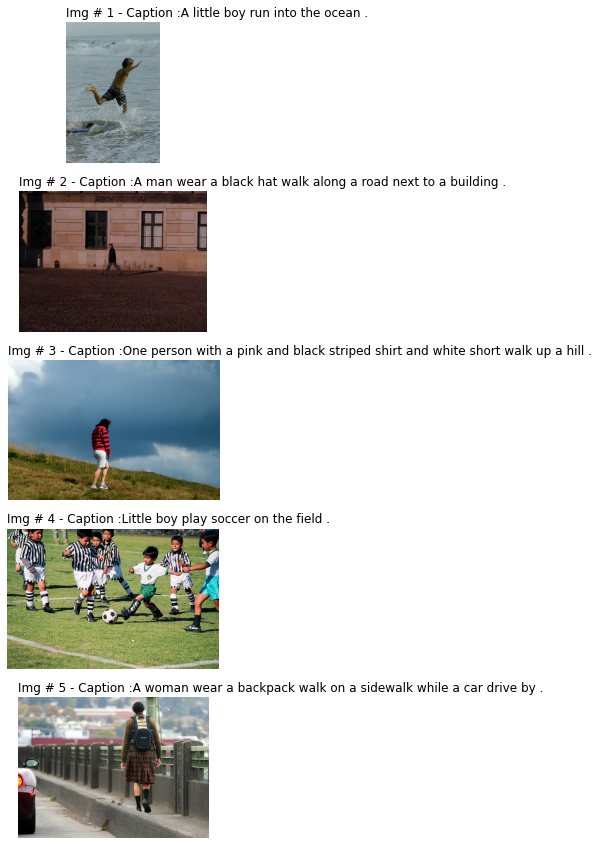

In [32]:
print_sample_imgs(IMAGE_DATA_FOLDER, os.listdir(IMAGE_DATA_FOLDER), nrows=5, ncols=1, nimages=5, df=raw_df)

In [34]:
def map_captions_images(captions_path, images_dir):
  captions_data = pd.read_pickle(captions_path)
  print('Captions data length = ', len(captions_data), '\n')

  captions_mapping = {} # dictionary mapping image names to captions
  captions_text = [] # list of all captions
  img_cnt = 0

  for i, row in enumerate(captions_data):
    img_name = str(row).split('#')[0] # get image name
    img_name = os.path.join(images_dir, img_name.strip()) # append image path
    img_caption = row.split('\t')[1] # get image caption

    if img_name.endswith("jpg"):
      img_caption = "<start> " + img_caption.strip() + " <end>" # add start & end token
      captions_text.append(img_caption)
      
      if img_name in captions_mapping:
        captions_mapping[img_name].append(img_caption)
      else:
        captions_mapping[img_name] = [img_caption]
        img_cnt = img_cnt + 1
  
  print('Total Images = ', img_cnt, '\n')

  return captions_mapping, captions_text

captions_mapping, captions_text = map_captions_images(CAPTIONS_PATH, IMAGE_DATA_FOLDER)

Captions data length =  25000 

Total Images =  8032 



**Data Preparation**

In [37]:
import numpy as np

def train_val_split(captions_mapping, train_size=0.8, shuffle=True):
    image_names = list(captions_mapping.keys()) # list of all image names

    if shuffle:
        np.random.shuffle(image_names) # shuffle

    train_size = int(len(captions_mapping) * train_size) # split into training & validation

    training_data = {
        img_name: captions_mapping[img_name] for img_name in image_names[:train_size]
    }
    validation_data = {
        img_name: captions_mapping[img_name] for img_name in image_names[train_size:]
    }

    return training_data, validation_data

training_data, validation_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))

Number of training samples:  6425
Number of validation samples:  1607


In [41]:
# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 20

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Number of self-attention heads
NUM_HEADS = 2

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE
LEARNING_RATE = 0.00001

In [44]:
def get_cleaned_text(text):
    strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~"
    text_lower = tf.strings.lower(text)
    return tf.strings.regex_replace(text_lower, "[%s]" % re.escape(strip_chars), "")


vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=get_cleaned_text,
)
vectorization.adapt(captions_text)

In [50]:
vectorization.get_vocabulary()[:15] # Top vocabulary words

['',
 '[UNK]',
 'a',
 '<start>',
 '<end>',
 'in',
 'be',
 'the',
 'on',
 'dog',
 'and',
 'man',
 'with',
 'of',
 'two']